# Swimmable Distance Matrix Network Preparation

To calculate a matrix of simmable distances between sites, we need a network that includes rivers and potential paths through the ocean between river mouths. This notebook documents the preparation of such a network for the east coast of the US and Canada.

In [1]:
%pylab inline
import pyriv
from pyriv import rg_light as rgl
import networkx as nx
import pandas as pd
import geopandas as gpd
import mplleaflet
import os
import pickle
from shapely.geometry import Point, LinearRing, Polygon, LineString

data_dir = '/Users/jkibele/Documents/RiverDistEastCoast/data/'
# Small short-cut functions
fp = lambda s: os.path.join(data_dir, s)
gdf_from_geoms = lambda gs: gpd.GeoDataFrame({'geometry': gs})
def gdf_merge(gdf_list):
    gdf = gpd.GeoDataFrame( pd.concat(gdf_list, ignore_index=True) )
    gdf.crs = gdf_list[0].crs
    return gdf

Populating the interactive namespace from numpy and matplotlib


The `pyriv` version used here is a pre-release version tagged as v0.3.0 in the repository.

The latest version (2.0) of NetworkX breaks my code, so I've purposely downgraded to version 1.11. The longer term solution will be to make `pyriv` compatible with the newer version. I'll print out the versions of other major dependencies here too.

In [2]:
print "NetworkX version: {}, Pandas version: {}, GeoPandas version: {}".format(nx.__version__, pd.__version__, gpd.__version__)

NetworkX version: 1.11, Pandas version: 0.20.3, GeoPandas version: 0.3.0


## Prepare Study Area Land Polygon

The US shapefile came from the [US Census Bureau](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html). I drew the study area polygon in QGIS.

In [3]:
sa = gpd.read_file(fp('studyArea.shp')).to_crs(epsg=5070)
usa_fn = fp('cb_2016_us_state_500k/cb_2016_us_state_500k.shp')
can_fn = fp('Canada.shp')
usa = gpd.read_file(usa_fn).to_crs(epsg=5070)
can = gpd.read_file(can_fn).to_crs(epsg=5070)

Merge US and Canda shapes.

In [4]:
keep_cols = ['NAME', 'geometry']
usacan = gpd.GeoDataFrame( pd.concat([usa[keep_cols], can[keep_cols]]) )
usacan.crs = usa.crs

Capture geometries that intersect the study region, combine them into a single geometry, and then use the study region to clip that geometry.

In [5]:
usacan['in_sa'] = usacan.intersects(sa.geometry.iloc[0])
ecoast = usacan[usacan.in_sa].copy()
ec_geom = ecoast.unary_union
ec_sa_geom = ec_geom.intersection(sa.geometry.iloc[0])

Save the geometry and view it.

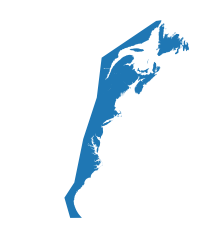

In [6]:
land_full = gpd.GeoDataFrame({'geometry': ec_sa_geom})
land_full.crs = usa.crs
land_full.to_file(fp('output/land_fullres_5070.shp'))
ax = land_full.plot()
ax.set_axis_off()

## Stream Subsetting

In [7]:
NE01fn = fp('NationalStreamInternetProject/Flowline_NE01_NSI.shp')
MA02fn = fp('NationalStreamInternetProject/Flowline_MA02_NSI.shp')
SA03Nfn = fp('NationalStreamInternetProject/Flowline_SA03N_NSI.shp')
SA03Sfn = fp('NationalStreamInternetProject/Flowline_SA03S_NSI.shp')
ne01 = gpd.read_file(NE01fn)
ma02 = gpd.read_file(MA02fn)
sa03n = gpd.read_file(SA03Nfn)
sa03s = gpd.read_file(SA03Sfn)

In [8]:
%%time
streams = gdf_merge([ne01, ma02, sa03n, sa03s]).to_crs(epsg=5070)
streams_sa = streams[streams.within(sa.geometry.item())]

CPU times: user 1min 18s, sys: 1.89 s, total: 1min 20s
Wall time: 1min 23s


This looks like a solid polygon, but it's just because there are so many rivers. It's actually line features.

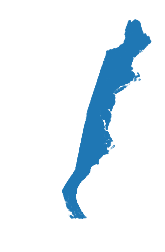

In [9]:
ax = streams_sa.plot()
ax.set_axis_off()

In [10]:
streams_sa.to_file(fp('output/NSI_flowlines_sa_clip.shp'))

## Preparing the Coastal Network

This was very processor intensive, so I ran this on the NCEAS analytical server using 20 processors. Even with that many processors it took about 5 hours. This was the script I used:

```python
import pandas as pd
import geopandas as gpd
import os
from pyriv.coastal import Land
import networkx as nx

## Setup: ######
data_dir = '/home/jkibele/Documents/ECRiverData/'
#data_dir = '/Users/jkibele/Documents/RiverDistEastCoast/data/'
fullpath = lambda s: os.path.join(data_dir, s)
full_land_fn = fullpath('land_fullres_5070.shp')
msq_threshold = 4e6
simp_num = 500
n_processors = 20

land_out_fn = fullpath('land{}m_5070.shp'.format(simp_num))
gpic_out_fn = fullpath('land{}m_5070.gpickle'.format(simp_num))

# read in the full resolution land shapefile
full_land = gpd.read_file(full_land_fn)
# dump small polygons and simplify the remains
big_enough = full_land.geometry.area > msq_threshold
lowres_land = full_land[big_enough].simplify(simp_num).buffer(0)
lowres_land.to_file(land_out_fn)
# generate the graph
lnd = Land(land_out_fn)
ecgraph = lnd.graph(n_jobs=n_processors)
nx.write_gpickle(ecgraph, gpic_out_fn)
```

This was run as a background process by issuing the following shell command in the same directory as the script:

```
python ECLandPrep2.py &
```

The `&` end makes it a background process. When the script was done, I downloaded the resulting shapefile and graph_pickle file.

## Further Subsetting and Completing Streams

This is the most complicated part of the process, and it's required because there's a mismatch between the streams dataset and the coastline of the land polygon. The biggest mismatch is in the estuaries. Many stream features end at the top (freshwater end) of an estuary while the land polygon considers the downstream portion of the estuary to be the coast. So there are 3 potential courses of action I need to consider for each site location:

1. Some points (i.e., sites) are not on land (call them '**ocean points**')
2. Others are (or will have paths to points that will be) close enough to the coast (< 4 km) that I will just **auto complete** them straight to the coast
3. Others are too far from the coast (or lead to river endpoints too far from the coast) to auto complete. These I'll need to **draw** a path for in QGIS

In order to figure out where I should auto complete, where I should draw, and where I'm done because I already have ocean points, I need a set of points to test. Where the original site point is on land, I need to test the end point if the site was close to a good river node but I'll need to test the original point if it's not. So, I need a column of point geometries representing river path end points or original points as is appropriate.

I'll use the original if it is not on land or if it is on land and not close to a good node. I'll use the end point if the original is on land and close to a good node. A 'good node' is not a dead end node (these lead no closer to the coast).

### Identify Test Points

In [11]:
# Load the simplified land polygon
lndfn = fp('land500m_5070.shp')
lnddf = gpd.read_file(lndfn)
# Load the study location sites
ale_fn = fp('reproj/locations_ALE_5070.shp')
bbh_fn = fp('reproj/locations_BBH_5070.shp')
ale = gpd.read_file(ale_fn)
bbh = gpd.read_file(bbh_fn)

A site was accidentally left out of the ALE sites, but is (correctly) included in the BBH sites. I need to copy it from BBH to ALE and put it in the correct position so the site order is maintained in the final distance matrix output. The site code is QUI, and it should occur between MBR and HOU in ALE.

In [12]:
bbh[bbh.Code=='QUI']

,Name,Code,Lat,Lon,geometry
21,Quinnipiac River,QUI,41.363467,-72.876988,POINT (1900689.96184805 2272064.221118273)


In [13]:
scds = ['MBR','HOU']
ale.query("Code in @scds")

,Name,Code,Lat,Lon,geometry
78,Quinnipiac River,MBR,41.342591,-72.311323,POINT (1946808.420572187 2281248.633303261)
80,Housatonic River,HOU,41.241190,-73.097933,POINT (1886150.079282553 2254373.303996091)


In [14]:
def insert_row(idx, df, df_insert):
    dfA = df.loc[:idx, ]
    dfB = df.loc[idx+1:, ]
    df = dfA.append(df_insert).append(dfB).reset_index(drop = True)
    return df

In [15]:
if 'QUI' not in ale.Code.tolist():
    print "Inserting"
    ale = insert_row(78, ale, bbh.query("Code == 'QUI'"))

In [16]:
ale.loc[78:81]

,Name,Code,Lat,Lon,geometry
78,Quinnipiac River,MBR,41.342591,-72.311323,POINT (1946808.420572187 2281248.633303261)
79,Quinnipiac River,QUI,41.363467,-72.876988,POINT (1900689.96184805 2272064.221118273)
80,Housatonic River,HOU,41.241190,-73.097933,POINT (1886150.079282553 2254373.303996091)
81,Pequonnock River,PEQ,41.196911,-73.186374,POINT (1880185.68025006 2247806.308259353)


In [17]:
# Add a species column
bbh['species'] = "BBH"
ale['species'] = "ALE"
sites = gdf_merge([ale, bbh])
# Test the sites to see which are on the land polygon
on_land = lambda g: not lnddf.disjoint(g).all()
sites['on_land'] = sites.geometry.apply(on_land)
print "Of {} total sites, {} are within the land polygon.".format(len(sites), sites.on_land.sum())

Of 145 total sites, 137 are within the land polygon.


Load the clipped streams that I created earlier into a `RiverGraph` object from the pyriv library. This will allow me to trace rivers down stream to their end points.

In [18]:
%%time
str_gr = nx.read_shp(fp('output/NSI_flowlines_sa_clip.shp'))
rgr = rgl.RiverGraph(data=str_gr)

CPU times: user 1min 9s, sys: 2.9 s, total: 1min 12s
Wall time: 1min 14s


In [19]:
%%time
distdf = rgl.deadend_distances(sites, rgr, node_distance=True)

CPU times: user 2min 21s, sys: 3.97 s, total: 2min 25s
Wall time: 2min 30s


In [20]:
def nearest_node_distance(rivgraph, pnt):
    clnd = rivgraph.closest_node(pnt)
    return Point(clnd).distance(pnt)

def is_near_good_node(rivgraph, pnt, threshold=4000):
    clnd = rivgraph.closest_node(pnt)
    close_enough = Point(clnd).distance(pnt) <= threshold
    good_node = not rivgraph.is_deadend(clnd)
    return good_node & close_enough

is_ngn = lambda p: is_near_good_node(rgr, p)
use_original = lambda p: (not on_land(p)) | (on_land(p) & (not is_ngn(p)))
use_endpnt = lambda p: on_land(p) & is_ngn(p)

distdf['is_ngn'] = distdf.geometry.apply(is_ngn)

In [21]:
%%time
distdf['testpnt_type'] = 'derp'
distdf.loc[distdf.geometry.apply(use_original), 'testpnt_type'] = 'original'
distdf.loc[distdf.geometry.apply(use_endpnt), 'testpnt_type'] = 'endpnt'
distdf.testpnt_type.value_counts()

CPU times: user 1min 25s, sys: 2.21 s, total: 1min 27s
Wall time: 1min 30s


In [22]:
path_end_pnt = lambda pth: Point(pth.coords[-1])
ep_ind = distdf.testpnt_type == 'endpnt'
distdf.loc[~ep_ind, 'testpnt'] = distdf.loc[~ep_ind, 'geometry']
distdf.loc[ep_ind, 'testpnt'] = distdf.loc[ep_ind, 'path'].apply(path_end_pnt)

### Decide What to do with each point

For test points in ocean, no action is required. For test points near the coast, I can auto complete (draw short line segments to combine with my network to bridge from river to coastal network). For test points on land and far from the coast, I will need to draw in the missing rivers in QGIS.

In [23]:
in_ocean = lambda p: (not on_land(p))
close_to_coast = lambda p: rgl.nearest_coast_pnt(lnddf, p, return_dist=True) <= 4000
def find_action(testpnt):
    if in_ocean(testpnt):
        return 'nothing'
    elif close_to_coast(testpnt):
        return 'auto'
    else:
        return 'draw'
    
distdf['action'] = distdf.testpnt.apply(find_action)
distdf.action.value_counts()

auto       66
nothing    43
draw       36
Name: action, dtype: int64

### Auto Complete

In [24]:
auto_comp = lambda pth: rgl.path_completion(lnddf, pth)
gdf_from_geoms = lambda gs: gpd.GeoDataFrame({'geometry': gs})
auto_comp_df = gdf_from_geoms(distdf.query("action=='auto'").testpnt.apply(auto_comp))
auto_comp_df.crs = distdf.crs
auto_comp_df.to_file(fp('output/auto_complete.shp'))

### Draw

I'll export the points that I need to draw paths for. I'll make sure to draw with snapping turned on, and I'll make sure to draw from the sites toward the ocean in case I need to use the paths in a directed graph. I also need to draw a connection for the East River.

In [25]:
pnts2draw = distdf.set_geometry('testpnt').query("action=='draw'")[['testpnt','Code','species']]
pnts2draw.to_file(fp('points_to_draw_from.shp'))

After drawing in QGIS (including the East River segement) load the drawn lines.

In [26]:
drawn = gpd.read_file(fp('draw_qgis_eastriver.shp'))
# drawn = gpd.read_file(fp('draw_qgis.shp'))

Double check to make sure I've gotten all the points I meant to:

In [27]:
touch_line = pnts2draw.geometry.apply(lambda p: (drawn.geometry.distance(p) < 0.0001).any())
print "{} points to draw from do not touch any drawn lines.".format((~touch_line).sum())

0 points to draw from do not touch any drawn lines.


Double check to make sure the end points of my drawn points are not on land. ...with the exception of 4 segements that are connected up an estuary.

In [28]:
draw_eps = drawn.geometry.apply(path_end_pnt)
lndgeom = lnddf.unary_union
lnd_shrink = lndgeom.buffer(-1)
draw_ep_onland = draw_eps.geometry.apply(lnd_shrink.intersects)
print "{} drawn path end points are on land.".format(draw_ep_onland.sum())

4 drawn path end points are on land.


### Subset the Study Area River Graph

I'll just keep the rivers I know I need. This will keep the data set a bit smaller, and these are the only rivers that I've verified get to the coast anyway.

In [29]:
nxsites = sites[sites.geometry.apply(use_endpnt)].copy()
nxsites['start_node'] = nxsites.geometry.apply(lambda g: rgr.closest_node(g))
subgraphs = nxsites.start_node.apply(lambda n: rgr.reachable_subgraph(n)).tolist()
subout = nx.compose_all(subgraphs)
nx.write_gpickle(subout, fp('output/river_subset.gpickle'))

### Attach the Auto-completed and Manually Drawn Bits

I'll leave the full river graph as a directed graph for now. That way it can be used to find the distance downstream to the ocean from each site. I'll add in the reverse directions when I've got it fully assembled.

In [30]:
drawn_graph = nx.read_shp(fp('draw_qgis.shp'))
auto_graph = nx.read_shp(fp('auto_complete.shp'))
full_rgr = rgl.RiverGraph(data=nx.compose_all([subout, auto_graph, drawn_graph])).weight_edges()

### Rounding!

Such a simple thing. When combining graphs, floating point error was causing the same point to come through as different nodes. 

In [31]:
full_rgr = pyriv.river_graph.node_rounding(full_rgr)
nx.write_gpickle(full_rgr, fp('output/full_rgr.gpickle'))
# write shapefile too
nx.write_shp(full_rgr, fp('full_rgr/'))
full_rgr_df = gpd.read_file(fp('full_rgr/edges.shp'))
full_rgr_df.crs = sites.crs

## Assemble the Whole Graph

Adde the assembled river graph to the coastal graph and reverse the graphs and the internal path segments to allow navigation up and down stream.

In [32]:
from pyriv.rg_light import json_linestring_reverse, full_reverse, add_reverse
coast_graph = pyriv.river_graph.node_rounding(nx.read_gpickle(fp('land500m_5070.gpickle')))

In [33]:
total_multidigraph = add_reverse(nx.compose(nx.DiGraph(full_rgr), coast_graph.to_directed()))
total_unlinked = pyriv.coastal.Land(lnddf, graph=total_multidigraph)

### Identify the Link Nodes

The nodes that link the rivers to the coastal graph will need to have edges calculated. So those nodes need to be identified.

First, I need to make a new distance data frame using the assembled full river network.

In [34]:
newdist = rgl.deadend_distances(sites, full_rgr, True)

In [36]:
myround = lambda f: round(f, 3)
tround = lambda t: tuple([myround(f) for f in t])
path_end_node = lambda pth: tround(pth.coords[-1])
oceanpnts = newdist.query("node_dist >= 4000").geometry.apply(lambda p: tround(pyriv.point_to_tuple(p)))
riv_ends = newdist.query("node_dist < 4000").path.apply(path_end_node)
link_nodes = pd.concat([oceanpnts, riv_ends], ignore_index=True).unique()
pickle.dump(link_nodes, open(fp('output/link_nodes.pickle'), 'wb'))

In [37]:
%%time 
# took just under 9 min on MacBook Pro
# full_graph = total_unlinked.add_ocean_edges(link_nodes, n_jobs=6, radius=1.4e5)
# full_graph = add_reverse(full_graph)
# nx.write_gpickle(full_graph, fp('output/total_connected.gpickle'))
# if it's already been run and you don't want to wait:
full_graph = nx.read_gpickle(fp('output/total_connected.gpickle'))

CPU times: user 793 ms, sys: 44.4 ms, total: 837 ms
Wall time: 864 ms


In [38]:
nx_total_out_dir = fp('output/total_connected_shp/')
if not os.path.exists(nx_total_out_dir):
    print "making"
    !mkdir $nx_total_out_dir
nx.write_shp(full_graph, nx_total_out_dir)

Force the East River into the coast graph. Ideally, the east river should've been included as a passage in the land shapefile. It wasn't so this step is a work-around.

In [42]:
eastriv = drawn[drawn.id==101].geometry.item()
# round all the points so the ends line up with nodes
eastriv = LineString([tround(t) for t in eastriv.coords])

In [43]:
# The add_geom_edge field also updates full_graph in place
full_graph2 = rgl.add_geom_edge(full_graph, eastriv)
nx.write_gpickle(full_graph, fp('output/total_connected_with_eastriver.gpickle'))

In [44]:
fish_dist = pyriv.coastal.coastal_fish_distance
p0 = sites.loc[sites.Code=='SJR'].geometry.iloc[0]
p1 = sites.geometry.iloc[0]
p2 = sites.geometry.iloc[1]
p4 = sites.loc[sites.Code=='MIA'].geometry.iloc[0]
p5 = sites.loc[sites.Code=='HUD_BLA'].geometry.iloc[0]
gdf_from_geoms = lambda gs: gpd.GeoDataFrame({'geometry': gs})
fd_df = gdf_from_geoms([fish_dist(full_graph, p4, p5)])
fd_df.plot(linewidth=4.0, color='r', figsize=(6,6))
mplleaflet.display(epsg=5070)

The results were then checked and reformated [here](EC_Result_Check.ipynb).